# Non-negative Matrix Factorisation (NMF)

This notebooks aim is to demonstrate how NMF works by reconstructing a user generated dataset. It is hoped it may serve as a reference guide or a reminder of the principles of NMF.

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
import matplotlib
import ipywidgets as widgets
matplotlib.rc('font', **{'size'   : 18})

Here we will first define the components of the "observations" that we wish to reconstruct using NMF

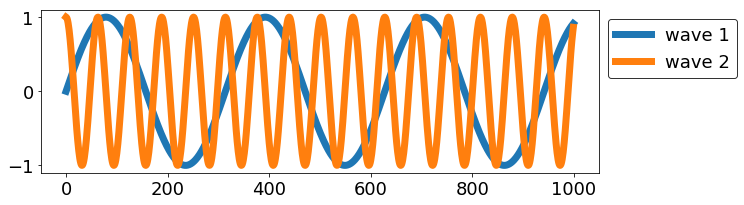

In [213]:
wave_1 =  np.sin(np.linspace(0,20,1000))
wave_2 =  np.cos(np.linspace(0,100,1000))

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(wave_1, lw=7, label="wave 1")
ax.plot(wave_2, lw=7, label="wave 2")
ax.legend(bbox_to_anchor=(1,1), edgecolor="k");

Construct 3 arrays that are a combination of the two sine waves. This is our "observation" dataset.

* wave_a = wave_1 + wave_2
* wave_b = wave_1 + (2 * wave_2)
* wave_c = (2 * wave_1) + wave_2

note the rescaling of the y axis - this is to stop the unrepresentatively large influence of outliers, and also to ensure no negative values are present.

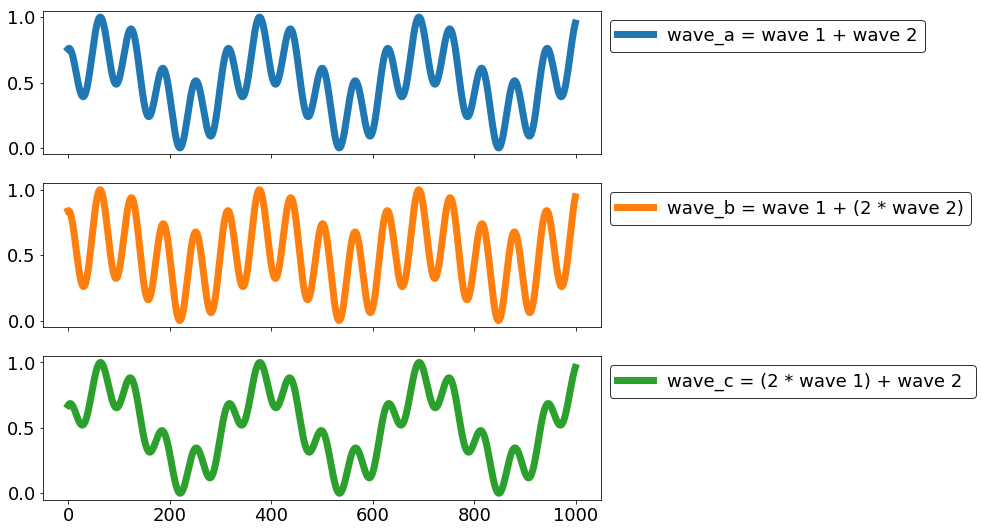

In [214]:
# The matrix to approximate
A_answer = np.array([
    wave_1 + wave_2,
    wave_1 + 2*(wave_2),
    wave_2 + 2*(wave_1),
]).T
labs = ["wave_a = wave 1 + wave 2",
        "wave_b = wave 1 + (2 * wave 2)",
        "wave_c = (2 * wave 1) + wave 2 "]

# Scale to between 0 - 1
A_answer = minmax_scale(A_answer)

# Get dimensions
# n = number of rows of W
# m = number of columns of H
n = A_answer.shape[0]
m = A_answer.shape[1]


# Plot
colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10,3*m), sharex=True, sharey=True, nrows=m)
for i in range(A_answer.shape[1]):
    ax[i].plot(A_answer.T[i], color=colors[i], lw=7, label=labs[i])
    ax[i].legend(bbox_to_anchor=(1,1), edgecolor="k");

First we set the number of factors (K) and make an initial guess at W and H.

In this instance we know K = 2 because we constructed waves a, b and c from waves 1 and 2. 

Deciding the value of K is half the battle with this analysis and quantitative methods exist for choosing that with NMF e.g. see [Brunet et al., 2004](https://www.pnas.org/content/101/12/4164.short)

In [215]:
# This is the choice of factors (how many columns of W and rows of H)
K = 2 

# initial guess of W and H
np.random.seed(1)
W_initial = np.round(np.mat(np.random.rand(n*K).reshape(n,K))/5, 1) + 0.1
H_initial = np.round(np.mat(np.random.rand(K*m).reshape(K,m))/5, 1) + 0.1

In [216]:
W_initial

array([[0.2, 0.2],
       [0.1, 0.2],
       [0.1, 0.1],
       ...,
       [0.3, 0.2],
       [0.1, 0.3],
       [0.1, 0.3]])

In [217]:
H_initial

array([[0.2, 0.3, 0.2],
       [0.2, 0.2, 0.2]])

In [218]:
np.matmul(W_initial, H_initial)

array([[0.08, 0.1 , 0.08],
       [0.06, 0.07, 0.06],
       [0.04, 0.05, 0.04],
       ...,
       [0.1 , 0.13, 0.1 ],
       [0.08, 0.09, 0.08],
       [0.08, 0.09, 0.08]])

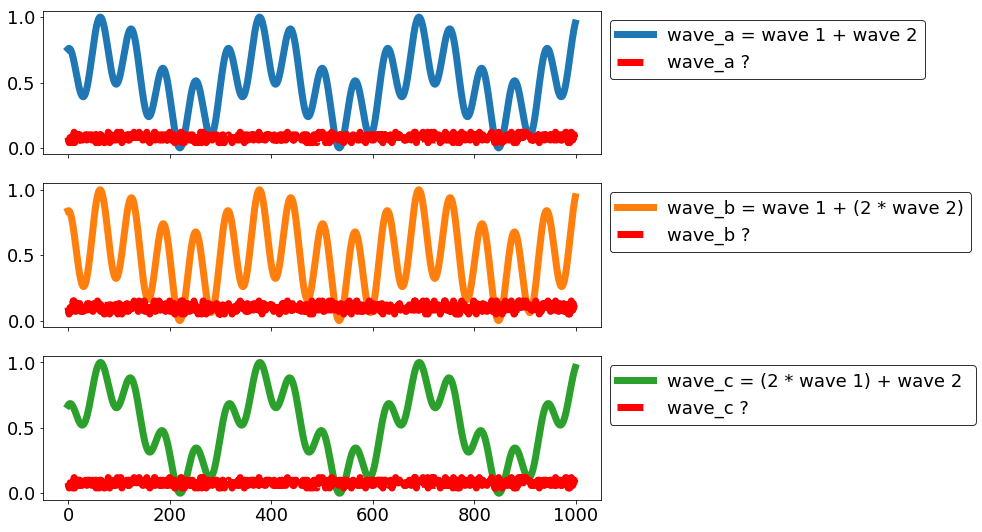

In [219]:
colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10,3*m), sharex=True, sharey=True, nrows=m)
for i in range(np.matmul(W_initial, H_initial).shape[1]):
        ax[i].plot(A_answer[:,i], color=colors[i], lw=7)
        ax[i].plot(np.matmul(W_initial, H_initial).T[i], color="r", lw=7, ls="--")

ax[0].legend([labs[0], "wave_a ?"], bbox_to_anchor=(1,1), edgecolor="k");
ax[1].legend([labs[1], "wave_b ?"], bbox_to_anchor=(1,1), edgecolor="k");
ax[2].legend([labs[2], "wave_c ?"], bbox_to_anchor=(1,1), edgecolor="k");

The initial guess is, of course, terrible.

Now we apply the update rules to W and H to improve the estimation

Updates are based on [Lee and Seung, 2001](https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf)

In [220]:
# Do the optimising this many times
n_iterations = 1000

# Going to store all the iterations of key variables in lists
# Hs are all the estimates of the row vectors (matrices) that contain the EFs
# Ws are all the estimates of column vectors (matrices) that contain the vehicle
# As are the reconstruction A ~ WH
# errs - cost function
# Initialise arrays to store data
errs = []
Hs = []
Ws = [] 
As = []
# append first guesses
Hs.append(H_initial)
Ws.append(W_initial)
As.append(A_answer)
errs = []

# This changes the order in the equation..
beta = 2 
for x in tqdm(range(n_iterations)):
#for x in range(n_iterations):

    # grab the matrices from the stored arrays from the previous iteration
    H = Hs[x].copy()
    W = Ws[x].copy()
    # Caclucate the cost function to be minimised
    err = 0
    for i in range(0, A_answer.shape[0]):
        for j in range(0, A_answer.shape[1]):
            err += (A_answer[i,j] - np.matmul(W, H)[i,j])**2

    # Update the estimation of H and W
    H = np.multiply(H, (np.matmul(W.T, np.multiply(np.matmul(W, H)**(beta-2), A_answer))/(np.matmul(W.T, np.matmul(W, H)**(beta-1)))))
    W = np.multiply(W, (np.matmul(np.multiply(np.matmul(W,H)**(beta-2), A_answer), H.T))/(np.matmul(np.matmul(W,H)**(beta-1), H.T)))    

    # store reconstruction and factors
    Hs.append(H.copy())
    Ws.append(W.copy())
    As.append(np.matmul(W, H))
    errs.append(err)

100%|██████████| 1000/1000 [00:27<00:00, 36.68it/s]


After x iterations, what does the cost function look like? 

Do we think x iterations is enough?

In [221]:
special_is = [1,7,50,500]

def logplot(LogX, LogY, showlabels):
    special_i_vals = [errs[x] for x in special_is]
    plt.plot(errs, zorder=1)        
    plt.ylabel("Cost function")
    plt.xlabel("iterations");
    if LogY:
        plt.yscale("log")
    if LogX:
        plt.xscale("log")
    if showlabels:
        for x, y in zip(special_is, special_i_vals):
            plt.scatter(special_is, [special_i_vals], zorder=10)
            plt.annotate(xy=(x,y),s="i={}".format(x))


ax = interact(logplot, LogX=False, LogY=False, showlabels=False);

interactive(children=(Checkbox(value=False, description='LogX'), Checkbox(value=False, description='LogY'), Ch…

Take a look at the reconstructions (WH) vs A at different iterations for each of the waves

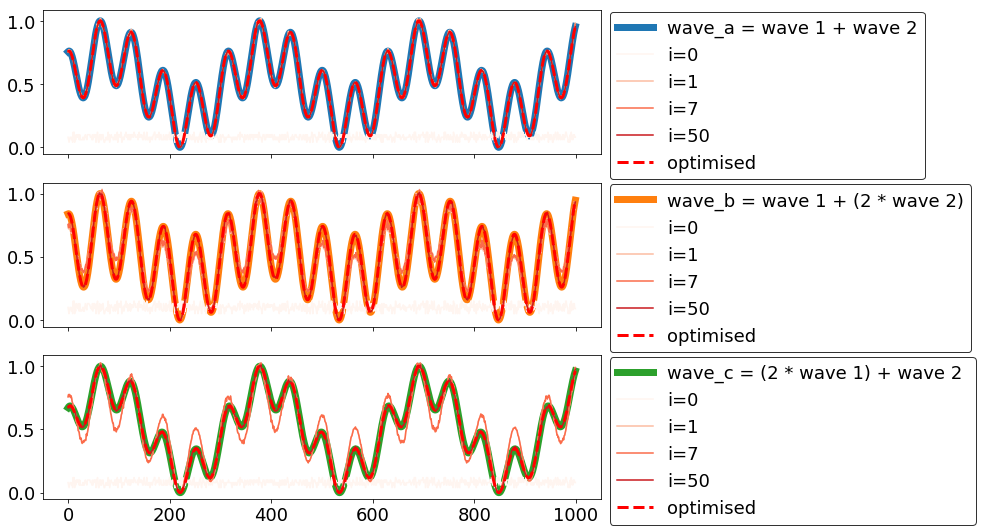

In [222]:
fig, ax = plt.subplots(figsize=(10,3*m), sharex=True, sharey=True, nrows=m)

colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
colors1=[cm.Reds(range(256))[int(x)] for x in np.linspace(0, 255, len(special_iss))]

special_iss = [0] + special_is
for i in range(m):
    ax[i].plot(A_answer[:,i], color=colors[i], lw=7)
    for j, n in enumerate(special_iss[:-1]):
        ax[i].plot(np.matmul(Ws[n], Hs[n])[:,i], color=colors1[j])
    ax[i].plot(As[special_iss[-1]][:,i], color="r", ls="--", lw=3)
    ax[i].legend(labels=[labs[i]] + ["i={}".format(x) for x in special_iss[:-1]] + ["optimised"],
                 bbox_to_anchor=(1,1.05), edgecolor="k")

In [223]:
Ws[1000]

array([[0.40105045, 0.23108411],
       [0.40056581, 0.23508708],
       [0.39819212, 0.23890999],
       ...,
       [0.3733743 , 0.40965876],
       [0.38552279, 0.41256891],
       [0.39613014, 0.41526015]])

In [224]:
Hs[1000]

array([[1.24504877, 1.7269484 , 0.75581875],
       [1.11075835, 0.63260256, 1.59574954]])

In [225]:
np.matmul(Ws[1000], Hs[1000])

array([[0.75600597, 0.83877783, 0.67187381],
       [0.75984891, 0.84047317, 0.67789525],
       [0.76113987, 0.83879232, 0.68220157],
       ...,
       [0.91990109, 0.90394932, 0.93591606],
       [0.93825904, 0.92677012, 0.949742  ],
       [0.95445502, 0.94679094, 0.96205378]])

['wave_a = wave 1 + wave 2',
 'wave_b = wave 1 + (2 * wave 2)',
 'wave_c = (2 * wave 1) + wave 2 ']

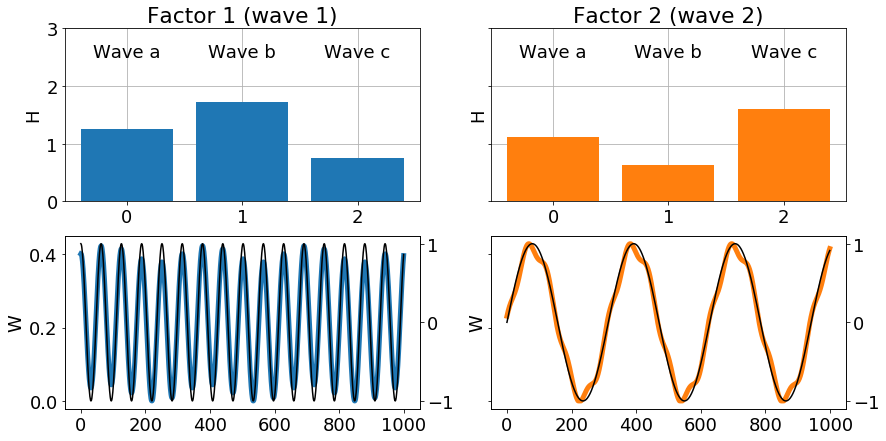

In [226]:
colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(7*K,7), sharex=False, sharey="row", ncols=K, nrows=2)
for i in range(K):
    # equivalent mass spec factors
    ax[0, i].bar(x=range(len(Hs[n_iterations][i])),
                 height=Hs[n_iterations][i], color=colors[i],
                 zorder=20)
    ax[0, i].set_title("Factor {} (wave {})".format(i+1, i+1))
    # Equivalent to factor time series
    ax[1, i].plot(Ws[n_iterations].T[i], color=colors[i], lw=5)
    ax[0, i].set_ylabel("H")
    ax[1, i].set_ylabel("W")
    ax[0, i].annotate(xy=(0, 2.5),s="Wave a", ha="center")
    ax[0, i].annotate(xy=(1, 2.5),s="Wave b", ha="center")
    ax[0, i].annotate(xy=(2, 2.5),s="Wave c", ha="center")
    ax[0, i].set_ylim(0,3)
    ax[0, i].grid(zorder=1)

ax[1, 0].twinx().plot(wave_2, color="k");
ax[1, 1].twinx().plot(wave_1, color="k");

labs

Notice the proportions of the Factors (H) equal the weighting of the contributing waves.

Also note the solution is not exact. 

This is partly due to the random initialisation. 

In reality the model should be run multiple times with different initial conditions to find the best solution.

Other more up to date algorithms exist as well!